#### Tweaking model - see if adding a third group helps this. using r/all as baseline. 

In [9]:
import pandas as pd
import numpy as np
import scipy as sp

import requests
import json
import time
from random import randint

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [8]:
#Filling this in for later application to new subs, if I get to it
#Figures as of 8/30/2018
dem_subscribers = 66.2 #Thousand
reb_subscribers = 52.4 #Thousand
dem_prior = dem_subscribers / (dem_subscribers + reb_subscribers)
rep_prior = 1 - dem_prior
dem_prior

0.5581787521079259

## Initial Pull (needed for fit_transform function default inputs)

In [3]:
#Pick up CSVs after recorded. Dems First
df_dems_1 = pd.read_csv('./Data/InitialDemocratsPosts_8_31.csv')
df_dems_2 = pd.read_csv('./Data/InitialDemocratsPosts_9_03.csv')
df_democrats_all = df_dems_1.append(df_dems_2.iloc[1:, ], ignore_index=True) #overlap from locked post

df_reps_1 = pd.read_csv('./Data/InitialRepublicanPosts.csv')
df_reps_2 = pd.read_csv('./Data/InitialRepublicanPosts_9_03.csv')
df_republicans_all = df_reps_1.append(df_reps_2, ignore_index=True)

#Null group sets
df_all_init = pd.read_csv('./Data/allPosts_9_04_A.csv')
df_cats_init = pd.read_csv('./Data/catsPosts_9_03_A.csv')
df_dogs_init = pd.read_csv('./Data/dogsPosts_9_03_A.csv')
df_hbb_init = pd.read_csv('./Data/hbbPosts_9_04_A.csv')

df_init_DemRep = df_democrats_all.append(df_republicans_all, ignore_index=True, verify_integrity=True)
for df in [df_all_init,df_cats_init, df_dogs_init, df_hbb_init]:
    df_init_DemRep =  df_init_DemRep.append(df, ignore_index=True, verify_integrity=True)
    

print('    Data Shape: ',df_init_DemRep.shape)
#Value counts check out. Looks like we got an extra Dem post from that locked post.
print('    Duplicate headers (expect count 2): ', len([label for label in df_init_DemRep['subreddit'].value_counts().index if label =='democrats' or label =='Republican']))  #Expect 2

#Translate to 0, 1, 2 groups
df_init_DemRep['subred_cat'] = (df_init_DemRep['subreddit']=='democrats')*2 + (df_init_DemRep['subreddit']=='Republican')*1
df_init_DemRep.fillna(' ', inplace=True)
print('    nulls: ', df_init_DemRep.isnull().sum())
print('    new counts: ', df_init_DemRep['subred_cat'].value_counts())

    Data Shape:  (4004, 3)
    Duplicate headers (expect count 2):  2
    nulls:  selftext      0
subreddit     0
title         0
subred_cat    0
dtype: int64
    new counts:  0    2003
2    1001
1    1000
Name: subred_cat, dtype: int64


## Custom Functions

#### Fit Transform

In [4]:
my_stop_words = stop_words.ENGLISH_STOP_WORDS
#no compelling reason to pull in self-text
df_data = df_init_DemRep.loc[:, ['subred_cat', 'title']]
def fit_transform_model(X=df_data.title, y=df_data.subred_cat, 
                        vecmod='TFID', pred='logreg', 
                        test_size_local=None, random_state_local=42 ):
    """I absolutely created this function after running through the lab the first time. 
    I figured that it would help me clean up the rest of the document, as well as making
    additions to the model.
    With a little bit of work, this should be very generalizable to future models for me."""
    
    #get vectorizer
    if vecmod == 'TFID':
        vecmod_ = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1,3))
    else:
        vecmod_ = vecmod
    
    #TTS, 
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size_local, 
                                                        random_state=random_state_local)
    X_train_transform = vecmod_.fit_transform(X_train).todense()
    df_X_train_transform = pd.DataFrame(X_train_transform, columns=vecmod_.get_feature_names())
    X_test_transform = vecmod_.transform(X_test).todense()
    df_X_test_transform = pd.DataFrame(X_test_transform, columns=vecmod_.get_feature_names())
    
    #predict model
    if pred == 'logreg':
        funct_model_= LogisticRegression()
    else:
        funct_model_ = pred
        
    funct_model_.fit(df_X_train_transform, y_train)
    
    #Export features and scores
    global latest_model, latest_transform, sorted_d_values_none, sorted_d_values_rep, sorted_d_values_dem, train_x, test_x, test_y, train_y
    latest_model = funct_model_ 
    train_x, test_x, train_y, test_y = df_X_train_transform, df_X_test_transform, y_train, y_test
    latest_transform = vecmod_
    
    try:
        feature_values_none =(dict(zip(list(df_X_train_transform.columns), list(funct_model_.coef_[0]))))
        sorted_d_values_none = sorted({(value, key) for (key,value) in feature_values_none.items()}, reverse=True)
        
        feature_values_rep =(dict(zip(list(df_X_train_transform.columns), list(funct_model_.coef_[1]))))
        sorted_d_values_rep = sorted({(value, key) for (key,value) in feature_values_rep.items()}, reverse=True)
        
        feature_values_dem =(dict(zip(list(df_X_train_transform.columns), list(funct_model_.coef_[2]))))
        sorted_d_values_dem = sorted({(value, key) for (key,value) in feature_values_dem.items()}, reverse=True)

    except:
        print('   broken sorter')
        return funct_model_.score(df_X_test_transform, y_test)
    
    return funct_model_.score(df_X_test_transform, y_test)

#### Get New Data

In [16]:
def subreddit_getter(subreddit_source, your_name_bot, max_pulls=40):
    """Subreddit source is the thing you are trying to detect. should be literal string. E.G., /r/football should be input as 'football'
    your_name_bot will be used to associate calls on your machine.
    neutral sub is a sub you believe to not be similar
    
    NB: Save function assumes Data subfolder exists in working directory.
    """
    data_list = []
    base_url = "https://www.reddit.com/r/" + subreddit_source + "/.json"
    URL = base_url

    #seems to be a cap around 20 for some smaller subs
    for step in range(max_pulls):
        try:
            data = requests.get(URL, headers={'User-agent': your_name_bot}).json()

            for i in range(len(data['data']['children'])):
                temp = {}
                temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
                temp['title']=data['data']['children'][i]['data']['title']
                data_list.append(temp)

            new_after = data['data']['after']
            URL = base_url + "?after=" + new_after
            print('    iteration {} worked. URL: {}'.format(step, URL))
                
            time.sleep(3)  #very important to avoid getting locked out by Reddit.
        except: 
            break
            
    df_scrape = pd.DataFrame(data_list)
    #Ensure unique name
    random_name = subreddit_source + str(randint(1, 100000)) #Avoid writing over previous csvs
    df_scrape.to_csv('./Data/' + random_name + '.csv')
    
    global df_latest_scrape
    df_latest_scrape = df_scrape
    
    print('    text file: ', random_name)
    print('    size: ', df_scrape.shape)

#### Subreddit Analyzer

In [43]:
def subreddit_Analysis(df_data_current_, output_figname=None):
    """Expected df format: df_data_current = pd.read_csv('./Data/repsbPosts_9_04_B.csv').loc[:, ['title']] 
    OR df_latest"""
    #Jump into analysis for this subreddit here from here
    
    X_cur = latest_transform.transform(df_data_current_.title).todense()
    df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                     columns=['Party'])

    df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['none_score','rep_score', 'dem_score'] ))

    '''The next 3 rows mimic the output of a 2 category model with type republican =0, democrat=1. 
    Since we are asking, what is the dominant party ranking for this sub, other than none, we want some intentionally biased results.'''
    df_cur_predictions['NewDem'] = 1*(df_cur_predictions['dem_score'] > df_cur_predictions['rep_score']) #Score whichever is higher proba
    #create 'Normalized' probabs based on the assumption that a post is either republican or democrat and never neither 
    df_cur_predictions['NewDem_proba'] = df_cur_predictions['dem_score']/(df_cur_predictions['dem_score']+df_cur_predictions['rep_score'])
    df_cur_predictions['NewRep_proba'] = 1 - df_cur_predictions['NewDem_proba']

    #Counts
    print('   None: ', len(df_cur_predictions[df_cur_predictions.Party == 0]))
    print('   Rep: ', len(df_cur_predictions[df_cur_predictions.Party == 1]))
    print('   Dem: ', len(df_cur_predictions[df_cur_predictions.Party == 2]))
    #Average party rating across all posts
    print('   Adj Dem Count: ', df_cur_predictions['NewDem'].sum())
    print('   Adj Rep Count: ', df_cur_predictions['NewDem'].count() - df_cur_predictions['NewDem'].sum())
    #Avg aggregate rating - >.5 indicates dem
    print('   Net: ', df_cur_predictions['NewDem'].mean())

    #summarize winning scores for each party 
    probas = df_cur_predictions.loc[:, ['NewDem_proba', 'NewRep_proba']]
    min_prob = .5
    dem_probs = []
    rep_probs = []
    for i in range(len(probas)):
        if probas.iloc[i][1] >min_prob:
            rep_probs.append(probas.iloc[i][1])
        elif probas.iloc[i][0]>min_prob:
            dem_probs.append(probas.iloc[i][0])
    print('   average dem score: ', sum(dem_probs) / len(dem_probs))
    print('   average rep score: ', sum(rep_probs) / len(rep_probs))
    #More republican or more dem scores?
    print('   net score: ', len(rep_probs) - len(dem_probs)) 

    net_probs = []
    for i in range(len(probas)):
        net_probs.append(probas.iloc[i][1] - probas.iloc[i][0]) #R minus D so that Republican == positive, 

    print('   net sum of probas: ', sum(net_probs))
    print('   mean proba delta: ', np.average(net_probs))
    print('   mode: ', sp.stats.mode(net_probs))
    print('   med: ', np.median(net_probs))
    
    if df_cur_predictions['NewDem'].mean() > .5: 
        wincolor = 'blue'
    else:
        wincolor = 'red'
    sns.distplot(net_probs, label='rep', color=wincolor)
    
    if output_figname is not None:
        plt.savefig('./Presentation/OutputFigs/' + output_figname + '.png')

## Model Assessment
---

In [5]:
fit_transform_model(test_size_local=.2)

0.8014981273408239

In [14]:
print('   none indicators:')
for i in range(10):
    print('    ', sorted_d_values_none[i])
#print('    democratic indicators: ', sorted_d[:-10])
print('\n    rep indicators:')
for i in range(10):
    print('    ', sorted_d_values_rep[i])
print('\n    dem indicators:')
for i in range(10):
    print('    ', sorted_d_values_dem[i])

   none indicators:
     (5.611738448785891, 'help')
     (3.9711631418586015, 'dog')
     (3.127261765291027, 'cat')
     (2.57944795429636, 'discussion')
     (1.876685001273597, 'dogs')
     (1.811047702858205, 'breeds')
     (1.5562430995005374, 'breed')
     (1.4505424076744973, 'little')
     (1.4223197142199957, 'old')
     (1.3140248902515075, 'love')

    rep indicators:
     (1.8117442133225576, 'liberals')
     (1.6367265811688123, 'senate')
     (1.585471302796486, 'walkaway')
     (1.3890949271144213, 'hc')
     (1.3869125345202595, 'brennan')
     (1.3669681607886188, 'media')
     (1.3397263388347898, 'republican')
     (1.3317468293628683, 'left')
     (1.3179722493103019, 'socialism')
     (1.2137656494541853, 'gop')

    dem indicators:
     (7.177275355534448, 'trump')
     (3.4461724377327134, 'president')
     (2.993538142074914, 'mccain')
     (2.5007589979018023, 'kavanaugh')
     (2.459963898494526, 'twitter')
     (2.3702938426215443, 'republicans')
     (2.236

In [15]:
cm = confusion_matrix(test_y, latest_model.predict(test_x))
df_cm = pd.DataFrame(cm, columns=['Predicted None', 'Pred Rep', 'Pred Dem'], index=['Actual None', 'Actual Rep', 'Actual Dem'])
df_cm

,Predicted None,Pred Rep,Pred Dem
Actual None,373,2,2
Actual Rep,86,108,18
Actual Dem,43,8,161


# Baseline Data Set Meta Analysis
---

## Word Cloud

In [27]:
#!pip install wordcloud

In [28]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/

In [14]:
from wordcloud import WordCloud

In [113]:
none_word_dict = dict(sorted_d_values_none[:21])
rep_word_dict = dict(sorted_d_values_rep[:50])
dem_word_dict = dict(sorted(sorted_d_values_dem[:50]))

In [18]:
from math import exp
import random

In [19]:
rep_word_dict_trans = {}
for key in rep_word_dict.keys():
    new_key_= int(exp(-key)*2000) #watch out for this negative
    while new_key_ in rep_word_dict.keys():
        new_key_+=1 #tie breaker prevents override of values
        print('    ',new_key_)
    rep_word_dict_trans[new_key_] = rep_word_dict[key]
rep_words_str = ''
for key in rep_word_dict_trans.keys():
    rep_words_str = rep_words_str + key*(str(rep_word_dict_trans[key]) + ' ')

In [20]:
dem_word_dict_trans = {}
for key in dem_word_dict.keys():
    new_key_= int(exp(key)*2000)
    while new_key_ in dem_word_dict.keys():
        new_key_+=1
        print('    ',new_key_)
    dem_word_dict_trans[new_key_] = dem_word_dict[key]
dem_words_str = ''
for key in dem_word_dict_trans.keys():
    dem_words_str = dem_words_str + key*(str(dem_word_dict_trans[key]) + ' ')
#dem_word_dict_trans

{6735: 'corruption',
 6756: 'gillum',
 6859: '2020',
 7189: 'administration',
 7747: 'say',
 7861: 'john',
 7879: 'campaign',
 8289: 'white house',
 8940: 'cohen',
 9165: 'white',
 9736: 'beto rourke',
 9990: 'beto',
 10413: 'gop',
 11616: 'rourke',
 18713: 'democrats',
 21401: 'republicans',
 23408: 'twitter',
 24383: 'kavanaugh',
 39912: 'mccain',
 62760: 'president',
 2618671: 'trump'}

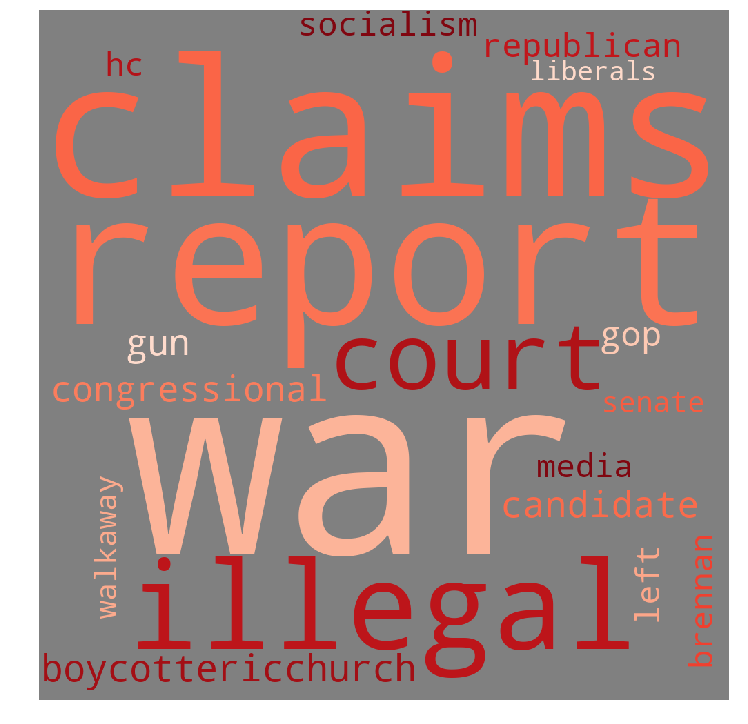

In [88]:
mycloud = WordCloud(width=1000, height=1000,
                    background_color='grey', 
                    colormap='Reds',
                    min_font_size=1,
                    max_words=len(rep_words_str),
                    collocations=False, #get rid of duplicates
                   normalize_plurals=False).generate_from_text(rep_words_str)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(mycloud)
plt.axis("off")
plt.tight_layout(pad = 0)
mycloud.to_file('./Presentation/OutputFigs/RepCloud_3.png')

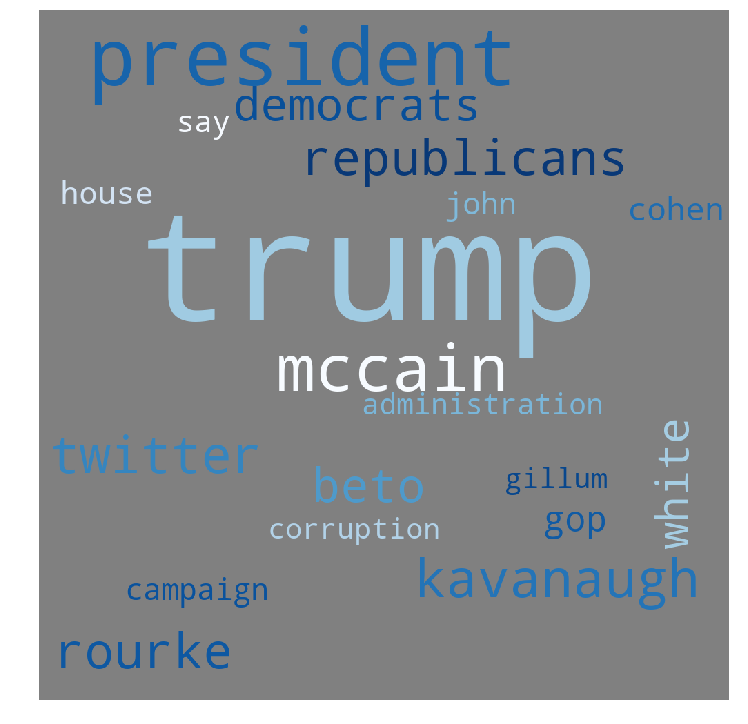

In [21]:
mycloud = WordCloud(width=1000, height=1000,
                    background_color='grey', 
                    min_font_size=1,
                    colormap='Blues',
                    collocations=False, #get rid of duplicates
                   normalize_plurals=False,
                   max_words=len(dem_words_str)).generate_from_text(dem_words_str)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(mycloud)
plt.axis("off")
plt.tight_layout(pad = 0)
mycloud.to_file('./Presentation/OutputFigs/DemCloud_3.png')

## Which posts were the most?

In [23]:
df_checker = pd.DataFrame(pd.Series(test_y))

In [24]:
df_checker['rep_score'] = [probas[i][1] for i in range(len(probas))]
df_checker['dem_score'] = [probas[i][2] for i in range(len(probas))]

In [25]:
#Most republican post
df_checker[df_checker['rep_score']==df_checker['rep_score'].max()]

,subred_cat,rep_score,dem_score
1788,1,0.577256,0.218682
1261,1,0.577256,0.218682


In [26]:
#Most democratic post
df_checker[df_checker['dem_score']==df_checker['dem_score'].max()]

,subred_cat,rep_score,dem_score
239,2,0.143783,0.76687


In [27]:
#The most democratic thing you could suggest right now:
#df_init_DemRep.iloc[96:97, :] no selftext...
df_init_DemRep['title'][239]

#After updates, still same post

'R.I.P. McCain'

In [28]:
#The most Republican thing you could suggest right now:
#df_init_DemRep.iloc[987:988, :]no selftext...
df_init_DemRep['title'][1261]

'GOP Congressional candidate Elizabeth Heng Gets Facebook Blocked'

In [29]:
df_init_DemRep['title'][1788] #REPOST

'GOP Congressional candidate Elizabeth Heng Gets Facebook Blocked'

## Word Clustering Analysis - why are scores happening?

In [ ]:
#Talk about overlap - words more tightly clustered for republican/

In [117]:
latest_model.intercept_ #Democrat intercept is more penalizing

array([ 0.2303148 , -1.2202583 , -1.43678538])

   demwords: 2297
   repwords: 1791
    4088


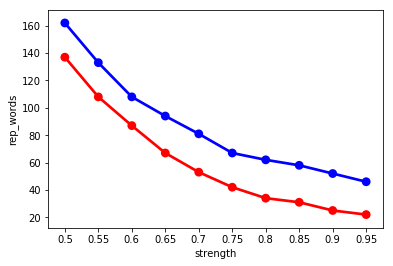

In [30]:
#How many words are above a given 'stregnth' score for dems vs. republicans
all_rep_words = { key:dict(sorted_d_values_rep)[key] for key in dict(sorted_d_values_rep).keys() if key>0 }
all_dem_words = { key:dict(sorted_d_values_dem)[key] for key in dict(sorted_d_values_dem).keys() if key>0 }
print('   demwords:', len(all_dem_words))
print('   repwords:', len(all_rep_words))
print('   ', len(all_rep_words)+len(all_dem_words))

results_list = []
for i in range(50,100, 5):
    j = i/100
    temp_dict = {}
    temp_dict['strength'] = j
    temp_dict['dem_words'] = len([key for key in dict(sorted_d_values_dem).keys() if key>j])
    temp_dict['rep_words'] = len([key for key in dict(sorted_d_values_rep).keys() if key>j])
    results_list.append(temp_dict)
    
#Democrats talk about more things
df_stregnths = pd.DataFrame(results_list)
sns.pointplot('strength','dem_words', data=df_stregnths, color='b')
sns.pointplot('strength','rep_words', data=df_stregnths, color='r')

    average dem score:  0.26338961507134206
    average rep score:  0.24336653846695983


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


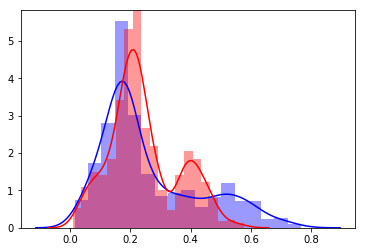

In [21]:
#compare predict probas
probas = latest_model.predict_proba(test_x)
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    rep_probs.append(probas[i][1])
    dem_probs.append(probas[i][2])
print('    average dem score: ', sum(dem_probs) / len(dem_probs))
print('    average rep score: ', sum(rep_probs) / len(rep_probs))
#Distribution of republican and Democrat strength scoring
sns.distplot(dem_probs, label='dem', color='blue') 
sns.distplot(rep_probs, label='rep', color='red')

In [43]:
'''
Interpretation: Republicans talk about fewer things, but those things are big indicators. Maybe it takes a higher number of keywords to trigger Dem prediction?
For the purposes of applying this to a random subreddit, 
we want scores outside [.38 to .62], to be safe'''

'\nInterpretation: Republicans talk about fewer things, but those things are big indicators. Maybe it takes a higher number of keywords to trigger Dem prediction?\nFor the purposes of applying this to a random subreddit, \nwe want scores outside [.38 to .62], to be safe'

In [38]:
test_y[:10]

682     2
2771    0
2073    0
1163    1
3731    0
3598    0
2974    0
3198    0
2704    0
1947    1
Name: subred_cat, dtype: int32

In [39]:
latest_model.predict_proba(test_x)[:10]

array([[0.28148128, 0.22647896, 0.49203975],
       [0.82253709, 0.09586105, 0.08160185],
       [0.56017171, 0.22971746, 0.21011083],
       [0.51359402, 0.35802076, 0.12838522],
       [0.57029391, 0.23319379, 0.1965123 ],
       [0.78168082, 0.11254381, 0.10577537],
       [0.76108442, 0.09817446, 0.14074112],
       [0.95096032, 0.02006578, 0.0289739 ],
       [0.50651588, 0.24228378, 0.25120034],
       [0.50478231, 0.23113484, 0.26408286]])

In [43]:

latest_model.predict_proba(test_x).shape
test_y.shape

(801,)

In [ ]:
'''WHY IS THE LAST ONE PREDICTING REPUBLICAN IF THE PROBABILITY IS LOWER?????'''

# Outside Testing
---
Getting scores and validation from 3rd and 4th subreddit. 

## Back Testing: Does the model work on new posts from initial set?
Establishing a baseline for net scoring process

### r/All

In [13]:
subreddit_getter('all', 'CBH_Bot', max_pulls=25)

    iteration 0 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d5fta
    iteration 1 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d4v0t
    iteration 2 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d5kdm
    iteration 3 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d42b8
    iteration 4 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d5pgy
    iteration 5 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d53dh
    iteration 6 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d35bq
    iteration 7 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d60my
    iteration 8 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d3jkj
    iteration 9 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d4xwg
    iteration 10 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d2htg
    iteration 11 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d1fu0
    iteration 12 worked. URL: https://

   None:  614
   Rep:  0
   Dem:  11
   Adj Dem Count:  169
   Adj Rep Count:  456
   Net:  0.2704
   average dem score:  0.5624942866646281
   average rep score:  0.554794401106134
   net score:  287


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net sum of probas:  28.84942491614971
   mean proba delta:  0.0461590798658395
   mode:  ModeResult(mode=array([0.08536413]), count=array([64]))
   med:  0.07869978210695971


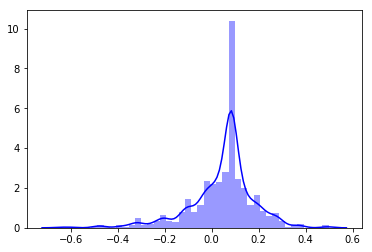

In [15]:
subreddit_Analysis(df_latest_scrape, output_figname='TestingA')

### r/Democrats

In [24]:
subreddit_getter('Democrats', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9d2xrk
    iteration 1 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9cvdbw
    iteration 2 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9cs73c
    iteration 3 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9cpgoh
    iteration 4 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9chcgk
    iteration 5 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9cfujx
    iteration 6 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9c9p21
    iteration 7 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9c4rb2
    iteration 8 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9bygjo
    iteration 9 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9bpvpj
    iteration 10 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9bkpbc
    iteration 11 worked. URL: https://www.reddit.com/

   None:  81
   Rep:  7
   Dem:  413
   Adj Dem Count:  480
   Adj Rep Count:  21
   Net:  0.9580838323353293
   average dem score:  0.6996334475942648
   average rep score:  0.5594256397636035
   net score:  -459


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net sum of probas:  -189.15223282042294
   mean proba delta:  -0.377549366907032
   mode:  ModeResult(mode=array([-0.49460827]), count=array([2]))
   med:  -0.4051791461497938


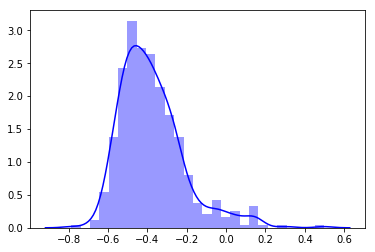

In [25]:
subreddit_Analysis(df_latest_scrape, 'Dems_3A')

### r/Republican

In [26]:
subreddit_getter('Republican', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9cg4z7
    iteration 1 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9bpt7f
    iteration 2 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9b9ias
    iteration 3 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9abkdq
    iteration 4 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_99x4pa
    iteration 5 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_99fdid
    iteration 6 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_98gnr6
    iteration 7 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9807r3
    iteration 8 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_976j7b
    iteration 9 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_96l0ye
    iteration 10 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_95xwsh
    iteration 11 worked. URL: https://www.

   None:  94
   Rep:  389
   Dem:  17
   Adj Dem Count:  31
   Adj Rep Count:  469
   Net:  0.062
   average dem score:  0.5901615300441141
   average rep score:  0.6978692579075709
   net score:  438


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net sum of probas:  180.01134905456698
   mean proba delta:  0.3600226981091338
   mode:  ModeResult(mode=array([0.08536413]), count=array([2]))
   med:  0.41349283113451796


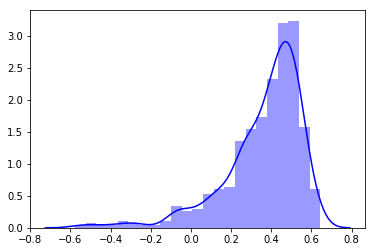

In [27]:
subreddit_Analysis(df_latest_scrape, 'reps_3A')

## Outside Testing: What does it look like on other subs?


### r/The_Donald


In [28]:
subreddit_getter('the_donald', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d60lx
    iteration 1 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d6s9f
    iteration 2 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d6opz
    iteration 3 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9czjf5
    iteration 4 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d5vzv
    iteration 5 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d20v8
    iteration 6 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d0yml
    iteration 7 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9cya26
    iteration 8 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d2hsb
    iteration 9 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d85gl
    iteration 10 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d4tb4
    iteration 11 worked. URL: https://www.

   None:  349
   Rep:  35
   Dem:  118
   Adj Dem Count:  264
   Adj Rep Count:  238
   Net:  0.5258964143426295
   average dem score:  0.619312529084731
   average rep score:  0.5766051457762524
   net score:  -26
   net sum of probas:  -26.53296596724171
   mean proba delta:  -0.05285451387896756
   mode:  ModeResult(mode=array([0.08536413]), count=array([9]))
   med:  -0.017180806911738844


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


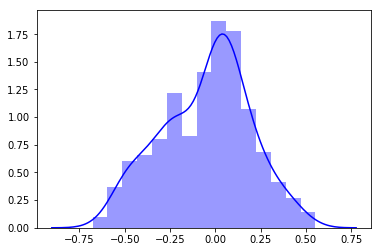

In [29]:
subreddit_Analysis(df_latest_scrape, 'the_donald_3A')

### r/cats


In [30]:
subreddit_getter('cats', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d7nol
    iteration 1 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d2i4h
    iteration 2 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d7vff
    iteration 3 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d5sth
    iteration 4 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d71w7
    iteration 5 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cwpqn
    iteration 6 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d2fxg
    iteration 7 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d7aiu
    iteration 8 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cwccm
    iteration 9 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cy342
    iteration 10 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d7ouw
    iteration 11 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d2ak8
    iteration 12 worked. U

   None:  499
   Rep:  0
   Dem:  1
   Adj Dem Count:  139
   Adj Rep Count:  361
   Net:  0.278
   average dem score:  0.5457206008719597
   average rep score:  0.550931860091165
   net score:  222


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net sum of probas:  24.062475943416082
   mean proba delta:  0.04812495188683215
   mode:  ModeResult(mode=array([0.08536413]), count=array([18]))
   med:  0.06319781272403308


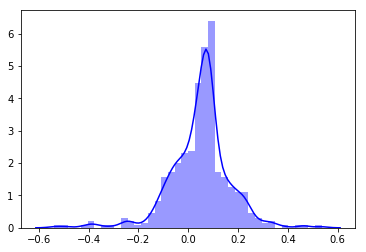

In [31]:
subreddit_Analysis(df_latest_scrape, 'cats_3A')

### r/dogs


In [32]:
subreddit_getter('dogs', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cwr7h
    iteration 1 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9czr7m
    iteration 2 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9czbi7
    iteration 3 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cy1k9
    iteration 4 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cunrj
    iteration 5 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cs6eg
    iteration 6 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9clca9
    iteration 7 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cji11
    iteration 8 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cjgho
    iteration 9 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cf68f
    iteration 10 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cb1cw
    iteration 11 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9c98ki
    iteration 12 worked. U

   None:  502
   Rep:  0
   Dem:  0
   Adj Dem Count:  190
   Adj Rep Count:  312
   Net:  0.3784860557768924
   average dem score:  0.5410114142707823
   average rep score:  0.5318124345999343
   net score:  122


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net sum of probas:  4.26662176746181
   mean proba delta:  0.008499246548728705
   mode:  ModeResult(mode=array([-0.14737861]), count=array([6]))
   med:  0.021367407062665378


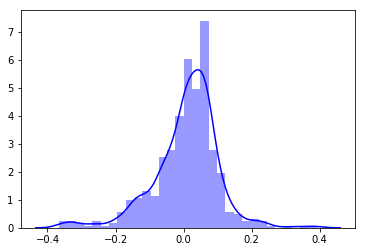

In [33]:
subreddit_Analysis(df_latest_scrape, 'dogs_3A')

### r/Communism


In [34]:
subreddit_getter('Communism', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_9coax5
    iteration 1 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_9c7kvs
    iteration 2 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_9bo4cb
    iteration 3 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_9afr1p
    iteration 4 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_99tysz
    iteration 5 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_99csmx
    iteration 6 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_988bti
    iteration 7 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_9794fi
    iteration 8 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_96xuui
    iteration 9 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_9663jb
    iteration 10 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_95oicc
    iteration 11 worked. URL: https://www.reddit.com/

   None:  447
   Rep:  31
   Dem:  22
   Adj Dem Count:  156
   Adj Rep Count:  344
   Net:  0.312
   average dem score:  0.5619341328324824
   average rep score:  0.579685699511391
   net score:  188


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net sum of probas:  35.50031182010245
   mean proba delta:  0.07100062364020496
   mode:  ModeResult(mode=array([0.08536413]), count=array([25]))
   med:  0.08380380574464028


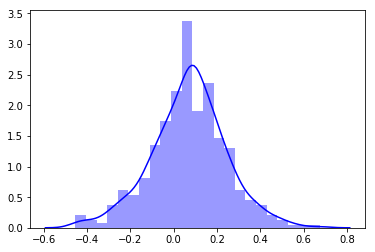

In [35]:
subreddit_Analysis(df_latest_scrape, 'commies_3A')

### r/libertarian


In [36]:
subreddit_getter('Libertarian', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9d5bj4
    iteration 1 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9d81iw
    iteration 2 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9d6e8c
    iteration 3 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9d79c2
    iteration 4 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9d79n5
    iteration 5 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9d0o5n
    iteration 6 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9d0nwc
    iteration 7 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9cwt6z
    iteration 8 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9cmrs3
    iteration 9 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9cwbdj
    iteration 10 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9cs0lo
    iteration 11 worked. URL: h

   None:  413
   Rep:  29
   Dem:  60
   Adj Dem Count:  185
   Adj Rep Count:  317
   Net:  0.36852589641434264
   average dem score:  0.5943062683880609
   average rep score:  0.5764703669190908
   net score:  132


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net sum of probas:  13.588893323120981
   mean proba delta:  0.027069508611794794
   mode:  ModeResult(mode=array([0.08536413]), count=array([22]))
   med:  0.061639478442377826


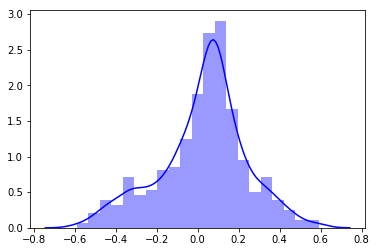

In [37]:
subreddit_Analysis(df_latest_scrape, 'libertarian_3A')

### r/Liberal


In [38]:
subreddit_getter('Liberal', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9cl4w3
    iteration 1 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9bgf1k
    iteration 2 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9a92pl
    iteration 3 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9971lr
    iteration 4 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_98lehf
    iteration 5 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_97bek2
    iteration 6 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_965q5m
    iteration 7 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_950y06
    iteration 8 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_944arl
    iteration 9 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_93kkts
    iteration 10 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_92d5ac
    iteration 11 worked. URL: https://www.reddit.com/r/Liberal/.json?after=

   None:  218
   Rep:  56
   Dem:  226
   Adj Dem Count:  304
   Adj Rep Count:  196
   Net:  0.608
   average dem score:  0.6327456982960288
   average rep score:  0.5892210426647281
   net score:  -108
   net sum of probas:  -45.73473583941239
   mean proba delta:  -0.09146947167882465
   mode:  ModeResult(mode=array([0.08536413]), count=array([2]))
   med:  -0.08197840861230365


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


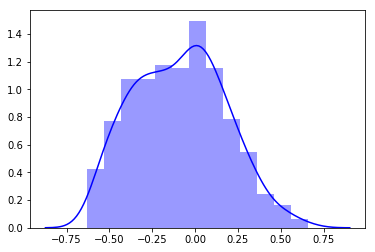

In [39]:
subreddit_Analysis(df_latest_scrape, 'Liberal_3A')

### r/GameofThrones


In [41]:
subreddit_getter('gameofthrones', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9cwtq2
    iteration 1 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9cl8tj
    iteration 2 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9ck662
    iteration 3 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9ce8b0
    iteration 4 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9c0lca
    iteration 5 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9bje1t
    iteration 6 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9b9xmn
    iteration 7 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9aycuc
    iteration 8 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9aig5w
    iteration 9 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9aejp8
    iteration 10 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9a6h88
    itera

   None:  502
   Rep:  0
   Dem:  0
   Adj Dem Count:  108
   Adj Rep Count:  394
   Net:  0.2151394422310757
   average dem score:  0.5409666020702975
   average rep score:  0.5446548326125095
   net score:  286
   net sum of probas:  26.339222051473115
   mean proba delta:  0.05246856982365156
   mode:  ModeResult(mode=array([0.08408008]), count=array([39]))
   med:  0.064559943739122


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


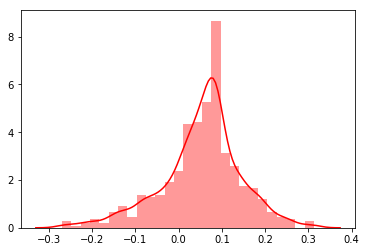

In [44]:
subreddit_Analysis(df_latest_scrape, 'GOT_3A')

### r/asoiaf


In [45]:
subreddit_getter('asoiaf', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9cvz46
    iteration 1 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9cb8w9
    iteration 2 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9c3kno
    iteration 3 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9bzvee
    iteration 4 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9bcc40
    iteration 5 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9bbee5
    iteration 6 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9azduy
    iteration 7 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9ai7vx
    iteration 8 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9amyj2
    iteration 9 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9a46xy
    iteration 10 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_99w5wh
    iteration 11 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_99v69p
  

   None:  501
   Rep:  0
   Dem:  1
   Adj Dem Count:  98
   Adj Rep Count:  404
   Net:  0.1952191235059761
   average dem score:  0.5444218043409741
   average rep score:  0.5459703549027098
   net score:  306
   net sum of probas:  28.437373110557736
   mean proba delta:  0.056648153606688664
   mode:  ModeResult(mode=array([0.08408008]), count=array([75]))
   med:  0.07959884980880769


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


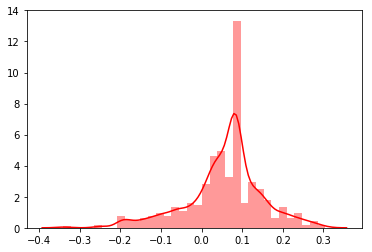

In [46]:
subreddit_Analysis(df_latest_scrape, 'asoiaf_3A')

### r/NFL


In [47]:
subreddit_getter('nfl', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cz75f
    iteration 1 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9d7nnc
    iteration 2 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9czbln
    iteration 3 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cvq44
    iteration 4 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cxqsa
    iteration 5 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cs7mx
    iteration 6 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cp32m
    iteration 7 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cnfh9
    iteration 8 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cwicv
    iteration 9 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cp4uq
    iteration 10 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9coeqv
    iteration 11 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9d00mo
    iteration 12 worked. URL: https://

   None:  495
   Rep:  3
   Dem:  4
   Adj Dem Count:  214
   Adj Rep Count:  288
   Net:  0.4262948207171315
   average dem score:  0.5601328019719376
   average rep score:  0.5575924992261081
   net score:  74
   net sum of probas:  7.436440310249116
   mean proba delta:  0.014813626116034104
   mode:  ModeResult(mode=array([0.08536413]), count=array([7]))
   med:  0.02895088196786827


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


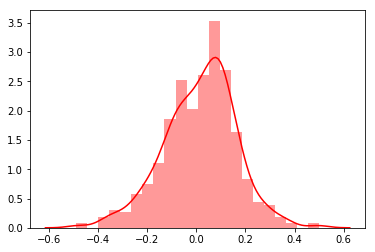

In [48]:
subreddit_Analysis(df_latest_scrape, 'NFL_3A')

### r/CFB


In [49]:
subreddit_getter('CFB', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9d830v
    iteration 1 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9d8d5d
    iteration 2 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9d2kig
    iteration 3 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9ct52k
    iteration 4 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9d0mxq
    iteration 5 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9cxf9g
    iteration 6 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9corp5
    iteration 7 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9cp7tl
    iteration 8 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9chgca
    iteration 9 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9cgdyp
    iteration 10 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9c7nka
    iteration 11 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9ccsju
    iteration 12 worked. URL: https://

   None:  490
   Rep:  7
   Dem:  5
   Adj Dem Count:  106
   Adj Rep Count:  396
   Net:  0.21115537848605578
   average dem score:  0.5427594236074563
   average rep score:  0.5759665300141442
   net score:  290
   net sum of probas:  51.10049396642157
   mean proba delta:  0.10179381268211461
   mode:  ModeResult(mode=array([0.2400976]), count=array([10]))
   med:  0.09752387793640457


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


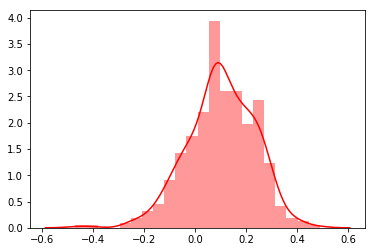

In [50]:
subreddit_Analysis(df_latest_scrape, 'CFB_3A')

### r/soccer


In [51]:
subreddit_getter('soccer', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9d0h1n
    iteration 1 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9d4vjc
    iteration 2 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9cvg80
    iteration 3 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9d3i4v
    iteration 4 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9cv0e3
    iteration 5 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9ctpxy
    iteration 6 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9cu9ry
    iteration 7 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9cxid1
    iteration 8 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9cv451
    iteration 9 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9ckunr
    iteration 10 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9cu0nv
    iteration 11 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9cnkdr
  

   None:  494
   Rep:  2
   Dem:  6
   Adj Dem Count:  161
   Adj Rep Count:  341
   Net:  0.3207171314741036
   average dem score:  0.5480253289307012
   average rep score:  0.5542315523194405
   net score:  180
   net sum of probas:  21.5217627661728
   mean proba delta:  0.04287203738281435
   mode:  ModeResult(mode=array([0.08536413]), count=array([16]))
   med:  0.05683782141617541


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


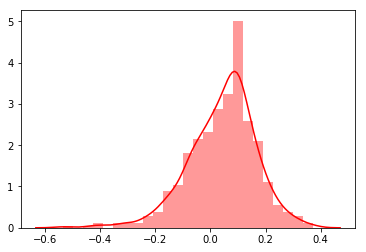

In [52]:
subreddit_Analysis(df_latest_scrape, 'soccer_3A')